# Image similarity example

In [1]:
import numpy as np
import random
import warnings
warnings.filterwarnings("ignore")
import tiledb
import PIL
import tensorflow_datasets as tfds
from tensorflow_datasets.core import dataset_utils

from tiledb.vector_search.object_api import object_index
from tiledb.vector_search.object_readers import TileDB1DArrayReader
from tiledb.vector_search.embeddings import ImageResNetV2Embedding

classes = np.array(["dandelion", "daisy", "tulips", "sunflowers", "roses"])

dataset = "tf_flowers"
base_uri = f"/tmp/{dataset}_tiledb_demo"
config = {}
image_array_uri = f"{base_uri}/tf_flowers"
metadata_array_uri = f"{base_uri}/tf_flowers_metadata"
index_uri = f"{base_uri}/index"
vfs = tiledb.VFS(config=config)

# Store images in a TileDB array

In [2]:
if vfs.is_dir(base_uri):
    vfs.remove_dir(base_uri)
vfs.create_dir(base_uri)

def save_images(ds):
    samples = dataset_utils.as_numpy(ds)
    size = len(samples)
    images = np.empty(size, dtype="O")
    shapes = np.empty(size, dtype="O")
    labels = np.zeros(size)
    image_ids = np.zeros(size)
    for i, sample in enumerate(samples):
        images[i] = sample['image'].flatten()
        shapes[i] = np.array(sample['image'].shape, dtype=np.uint32)
        labels[i] = sample['label']
        image_ids[i] = i
    with tiledb.open(image_array_uri, mode='w') as A:
        A[image_ids] = {"image": images, "shape": shapes}
    with tiledb.open(metadata_array_uri, mode='w') as A:
        A[image_ids] = {"label": labels}


with tiledb.scope_ctx(ctx_or_config=config):
    image_array_schema = tiledb.ArraySchema(
        domain = tiledb.Domain([
            tiledb.Dim(name="image_id", dtype=np.uint64, domain=(0, np.iinfo(np.uint64).max-100000), tile=1000)
        ]),
        attrs=[
            tiledb.Attr(name="image", dtype=np.uint8, var=True),
            tiledb.Attr(name="shape", dtype=np.uint32, var=True),
        ],
        sparse=True
    )
    tiledb.Array.create(image_array_uri, image_array_schema)

    metadata_array_schema = tiledb.ArraySchema(
        domain = tiledb.Domain([
            tiledb.Dim(name="image_id", dtype=np.uint64, domain=(0, np.iinfo(np.uint64).max-100000), tile=1000),
        ]),
        attrs=[
            tiledb.Attr(name="label", dtype=np.int64),
        ],
        sparse=True
    )
    tiledb.Array.create(metadata_array_uri, metadata_array_schema)

    ds, ds_info = tfds.load(dataset, split='train', with_info=True)
    save_images(ds)

# Create vector search index

In [3]:
reader = TileDB1DArrayReader(uri=image_array_uri, metadata_uri=metadata_array_uri, partition_tile_size=500, config=config)
embedding = ImageResNetV2Embedding()

if vfs.is_dir(index_uri):
    vfs.remove_dir(index_uri)

index = object_index.create(
    uri=index_uri,
    index_type="IVF_FLAT",
    object_reader=reader,
    embedding=embedding,
    config=config,
)
index.update_index(
    max_tasks_per_stage=5,
    workers=5,
)
index = object_index.ObjectIndex(uri=index_uri)

16/16 [==============================] - 18s 1s/step


# Query

Pick a random image from the dataset

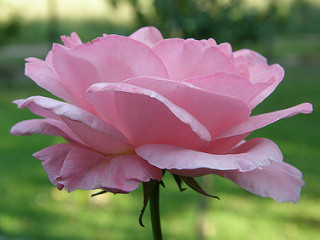

Class: roses


In [4]:
def display_image(images, image_id):
    display(PIL.Image.fromarray(np.reshape(images["image"][image_id], images["shape"][image_id])))
def display_related_image(images, image_id, related_image_id):
    display(PIL.Image.fromarray(np.reshape(images["image"][image_id, related_image_id], images["shape"][image_id, related_image_id])))
index = object_index.ObjectIndex(index_uri, config=config)

# rid = random.randint(0,3600)
rid = 1279
with tiledb.open(image_array_uri, mode='r', config=config) as A:
    query_image = A[rid]

with tiledb.open(metadata_array_uri, mode='r', config=config) as A:
    query_metadata = A[rid]
    query_label = query_metadata['label'][0]

display_image(query_image, 0)
print(f"Class: {classes[query_label]}")

## Similarity query

1/1 [==============================] - 0s 494ms/step


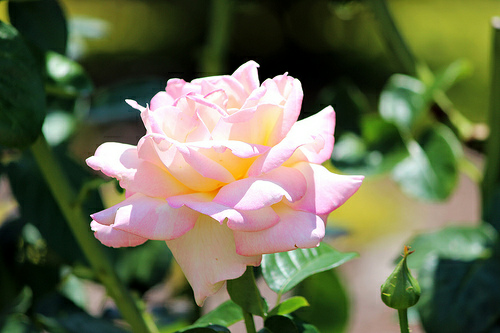

Class: roses


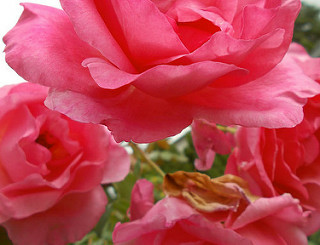

Class: roses


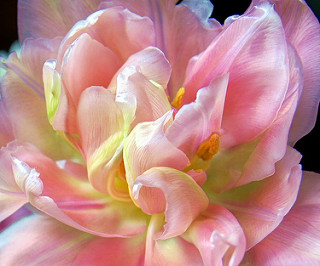

Class: tulips


In [5]:
distances, images, metadata = index.query(
                                        query_image, 
                                        k=4, 
                                        nprobe=10
                                    )

for image_id in range(images['image'].shape[0]):
    for related_image_id in range(1, images['image'].shape[1]):
        display_related_image(images, image_id, related_image_id)
        print(f"Class: {classes[metadata['label'][image_id, related_image_id]]}")

## Similarity query with structured restrict

Find similar images from the same flower class

1/1 [==============================] - 0s 59ms/step


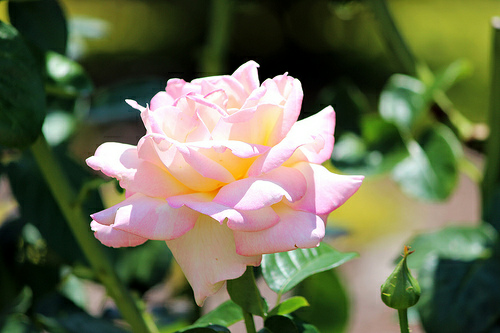

Class: roses


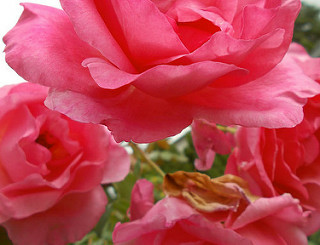

Class: roses


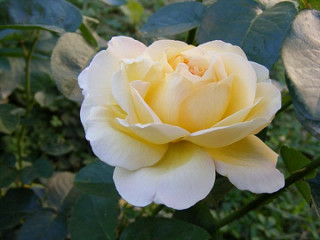

Class: roses


In [6]:
distances, images, metadata = index.query(
                                        query_image, 
                                        k=4, 
                                        metadata_array_cond=f"label == {query_label}", 
                                        nprobe=10
                                    )

for image_id in range(images['image'].shape[0]):
    for related_image_id in range(1, images['image'].shape[1]):
        display_related_image(images, image_id, related_image_id)
        print(f"Class: {classes[metadata['label'][image_id, related_image_id]]}")